In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.figsize'] = 25, 10

# Load and prepare data 

In [3]:
!head ./train.csv

In [4]:
# Test.csv has only inputs, not outputs, it's used by Kaggle to measure participants. 
# So we can't use the data at test.csv to test our predictions

all_data = pd.read_csv('./train.csv')

BETTER_COLUMN_NAMES = {
    'PassengerId': 'passenger_id',
    'Survived': 'survived',
    'Pclass': 'ticket_class',
    'Name': 'name',
    'Sex': 'sex',
    'Age': 'age',
    'SibSp': 'siblings_spouses',
    'Parch': 'parents_children',
    'Ticket': 'ticket',
    'Fare': 'fare',
    'Cabin': 'cabin',
    'Embarked': 'embarked_at',
    'Survived': 'survived',
}
all_data.rename(BETTER_COLUMN_NAMES, inplace=True, axis=1)

all_data.set_index('passenger_id', inplace=True)

all_data.shape

(891, 11)

In [5]:
all_data['age'].fillna(all_data.age.mean(), inplace=True)  # fill unknown ages with an average
all_data['embarked_at'].fillna('U', inplace=True)  # fill unknown embark locations with 'U' (from Unknown)

In [6]:
all_data

,survived,ticket_class,name,sex,age,siblings_spouses,parents_children,ticket,fare,cabin,embarked_at
passenger_id,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,NaN,S


# Output column will be: 

- survived

# We will use as inputs:

- sex: male/female
- age: numbers, many NaNs
- siblings_spouses: numbers, no NaNs
- parents_children: numbers, no NaNs
- ticket_class: 1/2/3
- fare: numbers, no NaNs
- embarked_at: C/Q/S and very few NaNs

# We won't use as inputs:

- passenger_id: this could only lead to overfitting
- name: this has a high change of leading to overfitting
- ticket: this could only lead to overfitting
- cabin: very little data, and maybe able to overfit? are these single family/person rooms?



In [7]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(all_data, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.5)

In [8]:
def evaluate_model(model, extract_inputs_function, extract_outputs_function, include_validation=False):
    sets = [('train', train), ('test', test)]
    if include_validation:
        sets.append(('validation', validation))
        
    for set_name, set_data in sets:
        inputs = extract_inputs_function(set_data)
        outputs = extract_outputs_function(set_data)
        predictions = model.predict(inputs)
        
        print(set_name, '#' * 80)
        
        # print metrics
        
        print('Accuracy:', accuracy_score(outputs, predictions))
        print('Precision:', precision_score(outputs, predictions))
        print('Recall:', recall_score(outputs, predictions))
        print()
        
        # plot confussion matrix
        
        plt.figure(figsize=(3,4))
        
        plt.xticks([0, 1], ['died', 'survived'], rotation=45)
        plt.yticks([0, 1], ['died', 'survived'])
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.title(set_name)

        plt.imshow(
            confusion_matrix(outputs, predictions), 
            cmap=plt.cm.Blues, 
            interpolation='nearest',
        )

        plt.show()

# First model: logistic regression

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
# final input columns, in the order we want to use them
LR_INPUT_COLUMNS = [
    'sex_m',
    'sex_f',
    'age',
    'siblings_spouses',
    'parents_children',
    'ticket_class',
    'fare',
    'embarked_at_c',
    'embarked_at_q',
    'embarked_at_s',
]


def lr_extract_inputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy()
    
    # sex to numbers
    inputs['sex_m'] = inputs.sex == 'male'
    inputs['sex_f'] = inputs.sex == 'female'
    del inputs['sex']
    
    # embarked at to numbers
    inputs['embarked_at_c'] = inputs.embarked_at == 'C'
    inputs['embarked_at_q'] = inputs.embarked_at == 'Q'
    inputs['embarked_at_s'] = inputs.embarked_at == 'S'
    del inputs['embarked_at']
    
    # return the raw numbers
    return inputs[LR_INPUT_COLUMNS].values.astype(np.float64)

def lr_extract_outputs(dataset):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return dataset.survived.values

In [11]:
lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression()),
])

In [12]:
lr_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

train ################################################################################
Accuracy: 0.8033707865168539
Precision: 0.7591623036649214
Recall: 0.7107843137254902



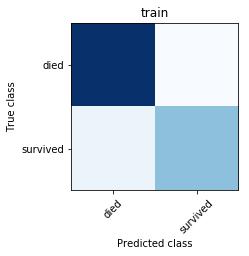

test ################################################################################
Accuracy: 0.7486033519553073
Precision: 0.676056338028169
Recall: 0.6857142857142857



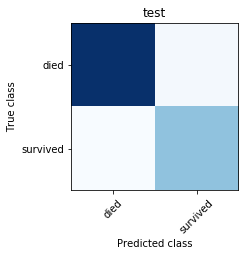

In [13]:
evaluate_model(lr_model, lr_extract_inputs, lr_extract_outputs)

In [14]:
lr_model.steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('classifier',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))]

In [15]:
clf = lr_model.steps[1][1]
clf.coef_

array([[-0.63281402,  0.63281402, -0.63386889, -0.33036009, -0.16737463,
        -0.91819646,  0.11458275, -0.03091352, -0.09686169, -0.31077737]])

In [16]:
for col_name, weight in zip(LR_INPUT_COLUMNS, clf.coef_[0]):
    print(col_name, ':', weight)

sex_m : -0.632814019673692
sex_f : 0.632814019673692
age : -0.6338688947846371
siblings_spouses : -0.33036009464777233
parents_children : -0.16737462726091995
ticket_class : -0.9181964631646309
fare : 0.11458274731959915
embarked_at_c : -0.03091351820975738
embarked_at_q : -0.09686168657586261
embarked_at_s : -0.31077737343707623


# Second model: K nearest neighbors

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
K = 10

knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

In [19]:
knn_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform'))])

train ################################################################################
Accuracy: 0.8389513108614233
Precision: 0.8470588235294118
Recall: 0.7058823529411765



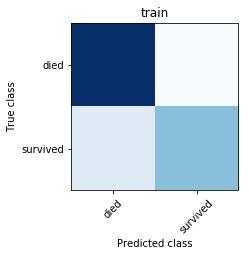

test ################################################################################
Accuracy: 0.8156424581005587
Precision: 0.8135593220338984
Recall: 0.6857142857142857



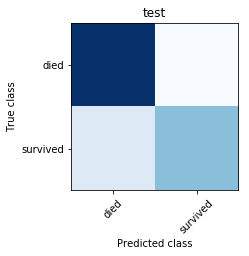

In [20]:
evaluate_model(knn_model, lr_extract_inputs, lr_extract_outputs)

# Third model: Decision Trees

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
# final input columns, in the order we want to use them
TREE_INPUT_COLUMNS = [
    'sex',
    'age',
    'siblings_spouses',
    'parents_children',
    'ticket_class',
    'fare',
    'embarked_at',
]


def tree_extract_inputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy()
    
    # sex to labels
    inputs['sex'] = inputs.sex.map({'male': 1, 'female': 2})

    # embarked_at to labels
    inputs['embarked_at'] = inputs.embarked_at.map({'C': 1, 'Q': 2, 'S': 3, 'U': 4})
    
    # return the raw numbers
    return inputs[TREE_INPUT_COLUMNS].values

def tree_extract_outputs(dataset):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return dataset.survived.values

In [23]:
tree_model = DecisionTreeClassifier()
# max_depth=3?

In [24]:
tree_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

train ################################################################################
Accuracy: 0.9887640449438202
Precision: 1.0
Recall: 0.9705882352941176



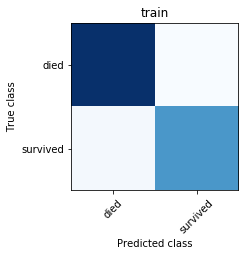

test ################################################################################
Accuracy: 0.6927374301675978
Precision: 0.6119402985074627
Recall: 0.5857142857142857



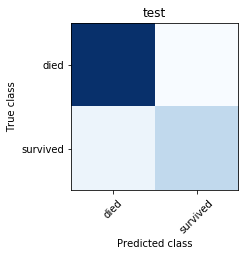

In [25]:
evaluate_model(tree_model, tree_extract_inputs, tree_extract_outputs)

In [26]:
import graphviz  # pip install graphviz
from sklearn.tree import export_graphviz

def graph_tree(tree):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=TREE_INPUT_COLUMNS,  
        class_names=['died', 'survived'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    # graph.render('rendered_tree')
    return graph

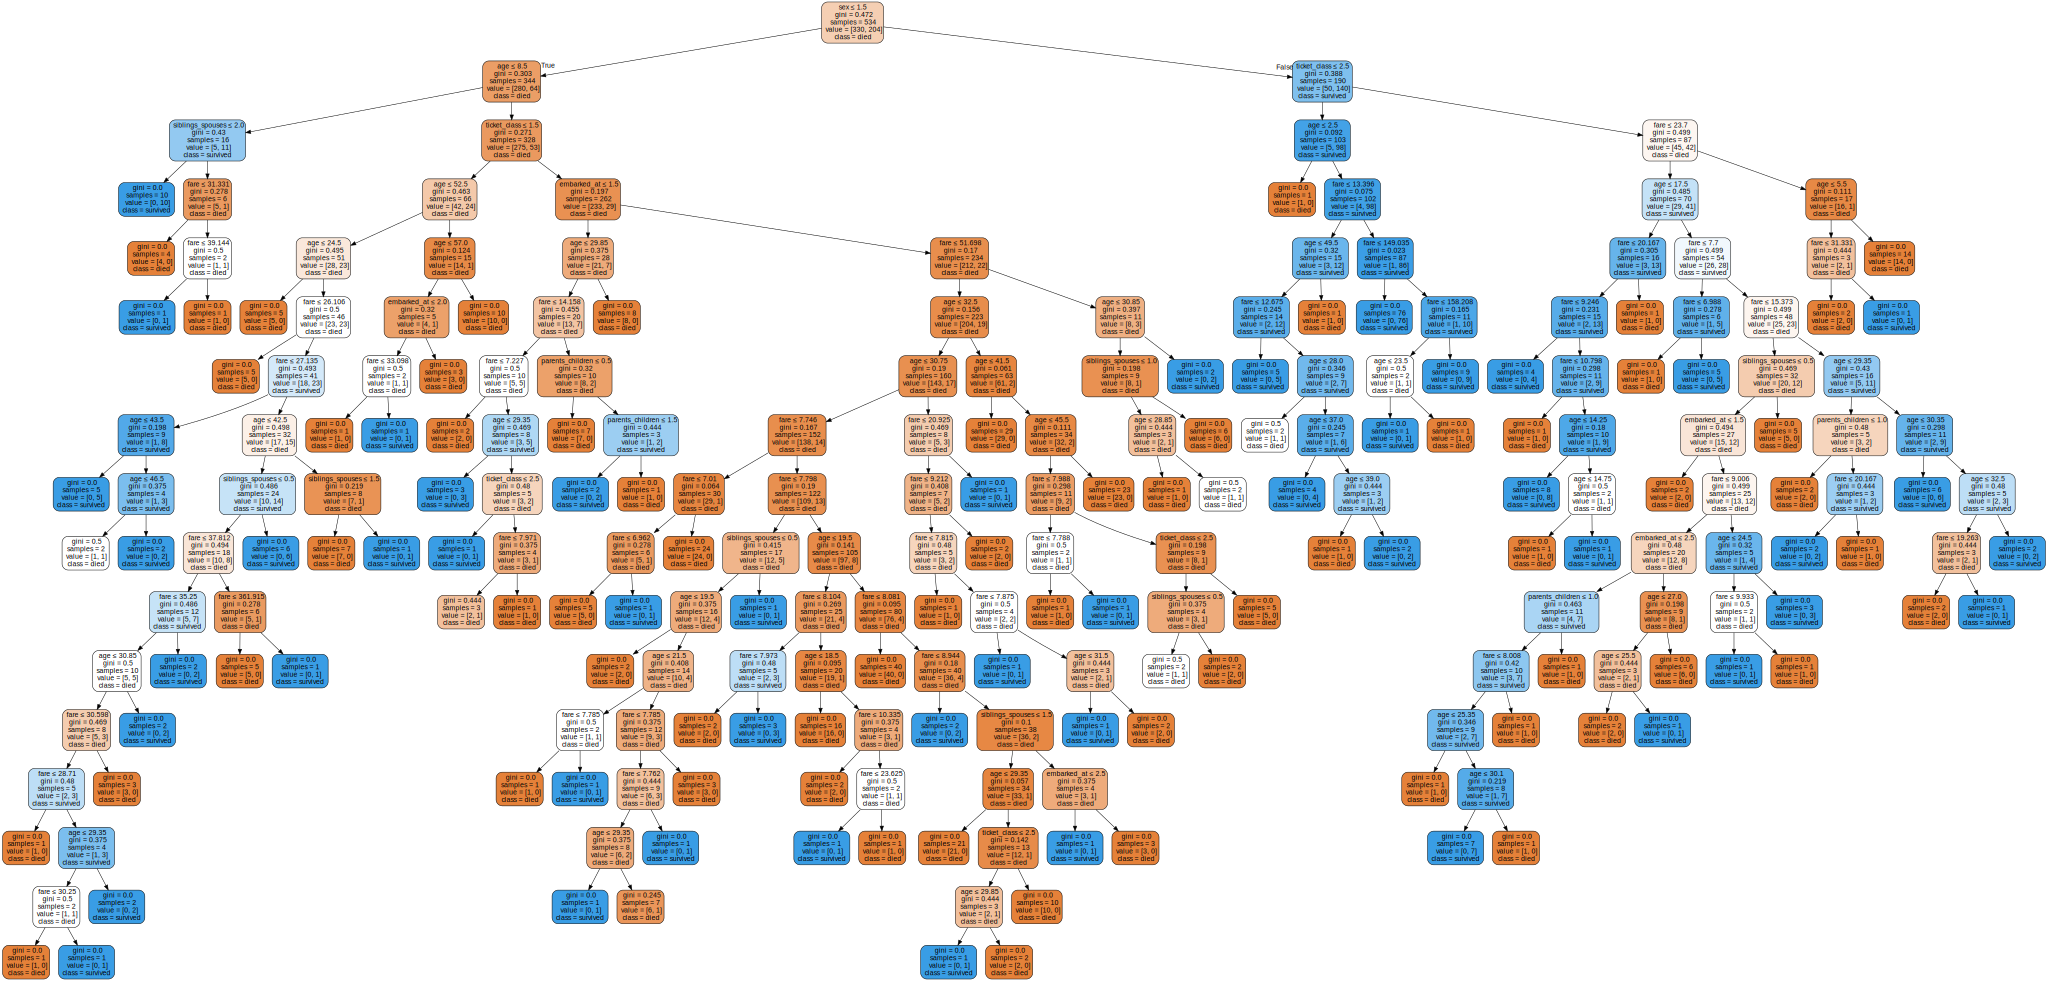

In [27]:
graph_tree(tree_model)

# Fourth model: Random Forests

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
forest_model = RandomForestClassifier()
# n_estimators? max_depth=3?, max_features=2?

In [30]:
forest_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

train ################################################################################
Accuracy: 0.9756554307116105
Precision: 0.9798994974874372
Recall: 0.9558823529411765



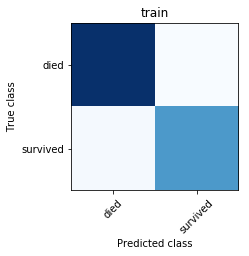

test ################################################################################
Accuracy: 0.7597765363128491
Precision: 0.6901408450704225
Recall: 0.7



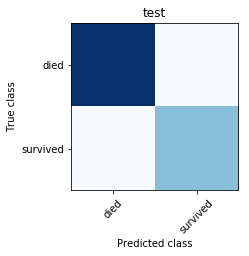

In [31]:
evaluate_model(forest_model, tree_extract_inputs, tree_extract_outputs)

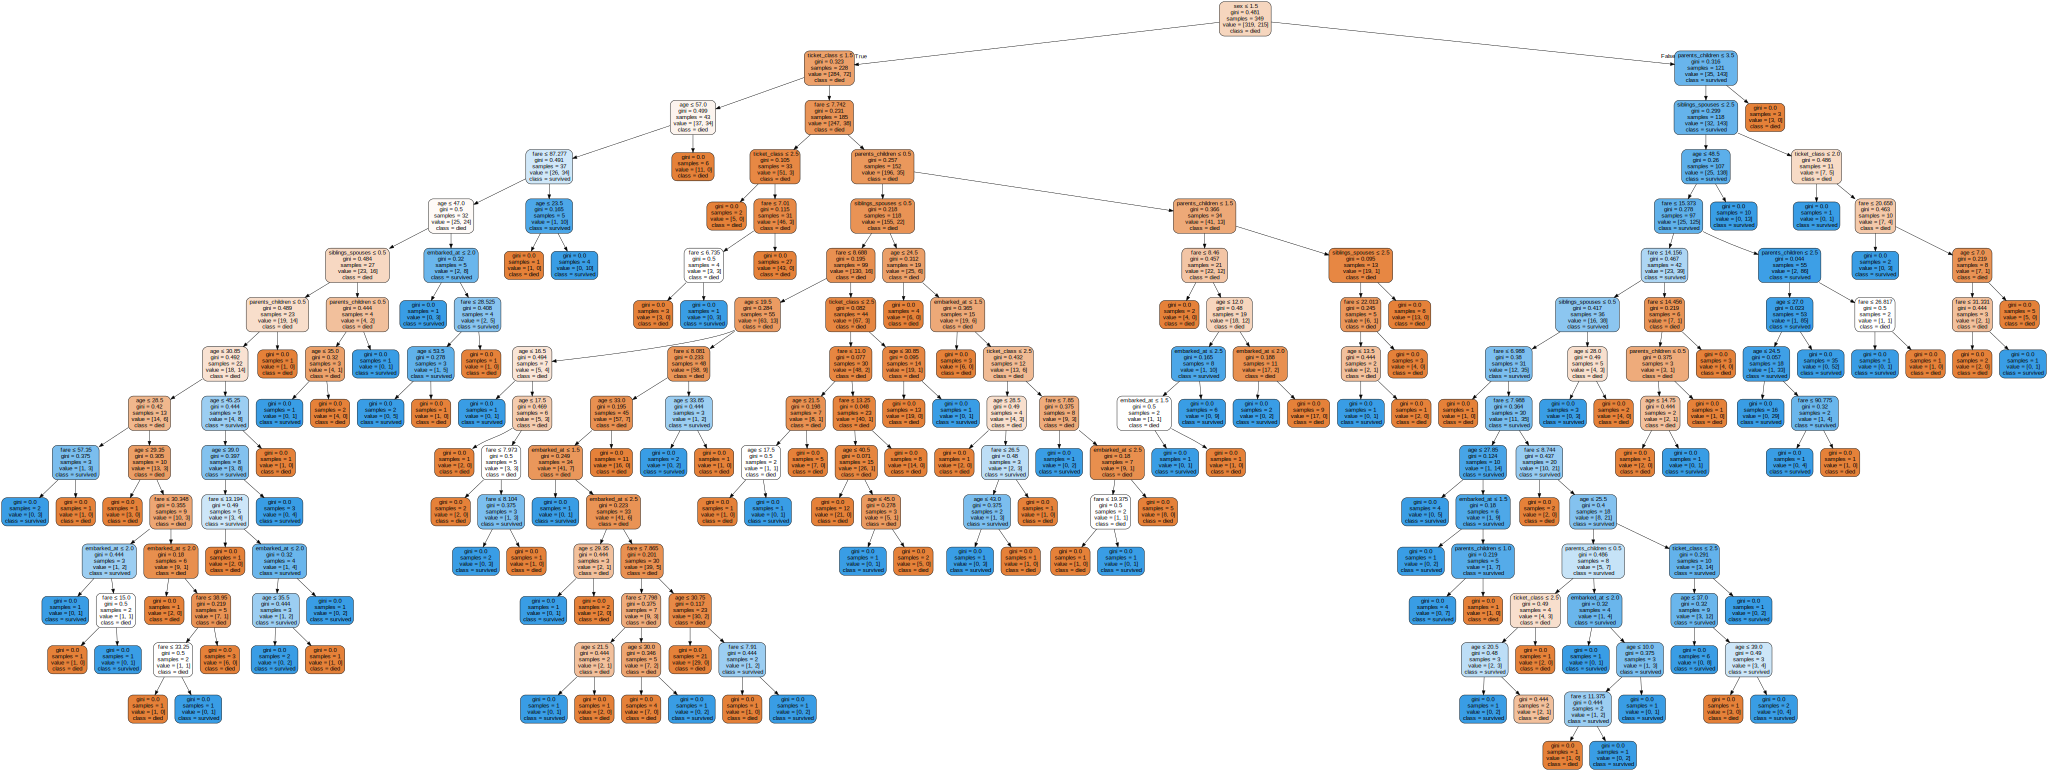

In [32]:
graph_tree(forest_model.estimators_[0])

# Fifth model: Gradient Boosted Trees

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

In [34]:
boost_model = GradientBoostingClassifier()

In [35]:
boost_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

train ################################################################################
Accuracy: 0.9213483146067416
Precision: 0.95
Recall: 0.8382352941176471



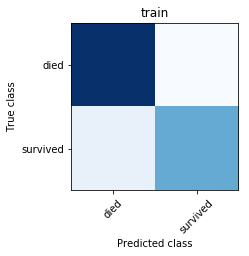

test ################################################################################
Accuracy: 0.7653631284916201
Precision: 0.7058823529411765
Recall: 0.6857142857142857



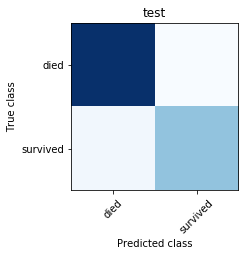

In [36]:
evaluate_model(boost_model, tree_extract_inputs, tree_extract_outputs)

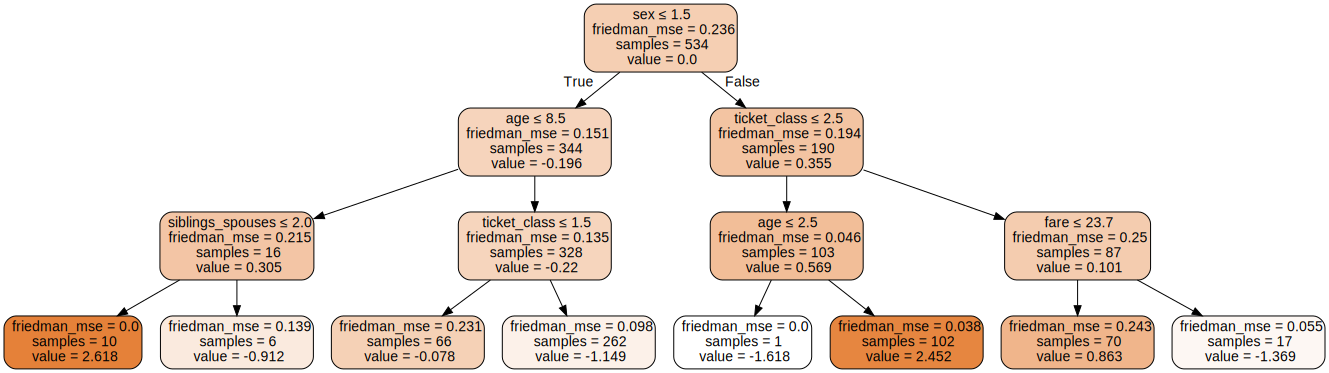

In [37]:
graph_tree(boost_model.estimators_[0][0])

# Sixth model: Neural Networks

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout

/home/fisa/venvs/ds/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [39]:
nn_model = Sequential([   
    Dense(100, input_shape=(len(LR_INPUT_COLUMNS), )),
    Activation('tanh'),
    
    Dropout(0.1),

    Dense(100),
    Activation('tanh'),
    
    Dropout(0.1),

    Dense(1),
    Activation('sigmoid'),
])

nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [40]:
history = nn_model.fit(
    lr_extract_inputs(train), 
    lr_extract_outputs(train),
    epochs=500,
    batch_size=128,
    validation_data=(
        lr_extract_inputs(test),
        lr_extract_outputs(test),
    )
)

Train on 534 samples, validate on 179 samples
Epoch 1/500
534/534 [==============================] - 0s 504us/step - loss: 0.6705 - acc: 0.6311 - val_loss: 0.6865 - val_acc: 0.6592
Epoch 2/500
534/534 [==============================] - 0s 25us/step - loss: 0.6090 - acc: 0.6966 - val_loss: 0.6818 - val_acc: 0.6201
Epoch 3/500
534/534 [==============================] - 0s 29us/step - loss: 0.6035 - acc: 0.6966 - val_loss: 0.6580 - val_acc: 0.6313
Epoch 4/500
534/534 [==============================] - 0s 24us/step - loss: 0.5961 - acc: 0.6910 - val_loss: 0.6365 - val_acc: 0.6369
Epoch 5/500
534/534 [==============================] - 0s 30us/step - loss: 0.5865 - acc: 0.6873 - val_loss: 0.6439 - val_acc: 0.6536
Epoch 6/500
534/534 [==============================] - 0s 24us/step - loss: 0.5843 - acc: 0.6873 - val_loss: 0.6363 - val_acc: 0.6313
Epoch 7/500
534/534 [==============================] - 0s 28us/step - loss: 0.5570 - acc: 0.7228 - val_loss: 0.6420 - val_acc: 0.6257
Epoch 8/500
534

534/534 [==============================] - 0s 26us/step - loss: 0.4353 - acc: 0.7959 - val_loss: 0.5039 - val_acc: 0.7598
Epoch 62/500
534/534 [==============================] - 0s 28us/step - loss: 0.4337 - acc: 0.8202 - val_loss: 0.5050 - val_acc: 0.7598
Epoch 63/500
534/534 [==============================] - 0s 32us/step - loss: 0.4287 - acc: 0.8015 - val_loss: 0.5363 - val_acc: 0.7430
Epoch 64/500
534/534 [==============================] - 0s 39us/step - loss: 0.4294 - acc: 0.8127 - val_loss: 0.5173 - val_acc: 0.7654
Epoch 65/500
534/534 [==============================] - 0s 31us/step - loss: 0.4171 - acc: 0.8240 - val_loss: 0.5086 - val_acc: 0.7709
Epoch 66/500
534/534 [==============================] - 0s 29us/step - loss: 0.4268 - acc: 0.8052 - val_loss: 0.5071 - val_acc: 0.7765
Epoch 67/500
534/534 [==============================] - 0s 35us/step - loss: 0.4283 - acc: 0.8109 - val_loss: 0.5112 - val_acc: 0.7877
Epoch 68/500
534/534 [==============================] - 0s 31us/step

534/534 [==============================] - 0s 27us/step - loss: 0.4075 - acc: 0.8184 - val_loss: 0.5139 - val_acc: 0.7877
Epoch 122/500
534/534 [==============================] - 0s 27us/step - loss: 0.3903 - acc: 0.8277 - val_loss: 0.5057 - val_acc: 0.7821
Epoch 123/500
534/534 [==============================] - 0s 30us/step - loss: 0.3941 - acc: 0.8333 - val_loss: 0.5123 - val_acc: 0.7765
Epoch 124/500
534/534 [==============================] - 0s 28us/step - loss: 0.4100 - acc: 0.8258 - val_loss: 0.5312 - val_acc: 0.7598
Epoch 125/500
534/534 [==============================] - 0s 30us/step - loss: 0.4023 - acc: 0.8296 - val_loss: 0.5307 - val_acc: 0.7486
Epoch 126/500
534/534 [==============================] - 0s 25us/step - loss: 0.3948 - acc: 0.8184 - val_loss: 0.5066 - val_acc: 0.7821
Epoch 127/500
534/534 [==============================] - 0s 26us/step - loss: 0.4093 - acc: 0.8221 - val_loss: 0.5145 - val_acc: 0.7709
Epoch 128/500
534/534 [==============================] - 0s 25

534/534 [==============================] - 0s 29us/step - loss: 0.3812 - acc: 0.8352 - val_loss: 0.5152 - val_acc: 0.7821
Epoch 182/500
534/534 [==============================] - 0s 25us/step - loss: 0.3909 - acc: 0.8221 - val_loss: 0.5451 - val_acc: 0.7374
Epoch 183/500
534/534 [==============================] - 0s 26us/step - loss: 0.3818 - acc: 0.8202 - val_loss: 0.5139 - val_acc: 0.7821
Epoch 184/500
534/534 [==============================] - 0s 30us/step - loss: 0.3922 - acc: 0.8202 - val_loss: 0.5055 - val_acc: 0.7821
Epoch 185/500
534/534 [==============================] - 0s 64us/step - loss: 0.3785 - acc: 0.8315 - val_loss: 0.5303 - val_acc: 0.7486
Epoch 186/500
534/534 [==============================] - 0s 36us/step - loss: 0.3608 - acc: 0.8446 - val_loss: 0.5083 - val_acc: 0.7542
Epoch 187/500
534/534 [==============================] - 0s 30us/step - loss: 0.3906 - acc: 0.8352 - val_loss: 0.5133 - val_acc: 0.7654
Epoch 188/500
534/534 [==============================] - 0s 23

534/534 [==============================] - 0s 27us/step - loss: 0.3622 - acc: 0.8371 - val_loss: 0.5363 - val_acc: 0.7486
Epoch 242/500
534/534 [==============================] - 0s 26us/step - loss: 0.3790 - acc: 0.8333 - val_loss: 0.5335 - val_acc: 0.7765
Epoch 243/500
534/534 [==============================] - 0s 27us/step - loss: 0.3616 - acc: 0.8539 - val_loss: 0.5365 - val_acc: 0.7486
Epoch 244/500
534/534 [==============================] - 0s 27us/step - loss: 0.3549 - acc: 0.8352 - val_loss: 0.5203 - val_acc: 0.7765
Epoch 245/500
534/534 [==============================] - 0s 28us/step - loss: 0.3699 - acc: 0.8502 - val_loss: 0.5205 - val_acc: 0.7933
Epoch 246/500
534/534 [==============================] - 0s 25us/step - loss: 0.3752 - acc: 0.8446 - val_loss: 0.5314 - val_acc: 0.7486
Epoch 247/500
534/534 [==============================] - 0s 28us/step - loss: 0.3781 - acc: 0.8464 - val_loss: 0.5282 - val_acc: 0.7486
Epoch 248/500
534/534 [==============================] - 0s 27

534/534 [==============================] - 0s 28us/step - loss: 0.3563 - acc: 0.8502 - val_loss: 0.5239 - val_acc: 0.7654
Epoch 302/500
534/534 [==============================] - 0s 25us/step - loss: 0.3607 - acc: 0.8483 - val_loss: 0.5238 - val_acc: 0.7765
Epoch 303/500
534/534 [==============================] - 0s 23us/step - loss: 0.3702 - acc: 0.8390 - val_loss: 0.5270 - val_acc: 0.7765
Epoch 304/500
534/534 [==============================] - 0s 26us/step - loss: 0.3475 - acc: 0.8464 - val_loss: 0.5218 - val_acc: 0.7821
Epoch 305/500
534/534 [==============================] - 0s 27us/step - loss: 0.3796 - acc: 0.8390 - val_loss: 0.5285 - val_acc: 0.7821
Epoch 306/500
534/534 [==============================] - 0s 28us/step - loss: 0.3639 - acc: 0.8521 - val_loss: 0.5335 - val_acc: 0.7598
Epoch 307/500
534/534 [==============================] - 0s 26us/step - loss: 0.3500 - acc: 0.8446 - val_loss: 0.5286 - val_acc: 0.7821
Epoch 308/500
534/534 [==============================] - 0s 30

534/534 [==============================] - 0s 24us/step - loss: 0.3448 - acc: 0.8483 - val_loss: 0.5406 - val_acc: 0.7542
Epoch 362/500
534/534 [==============================] - 0s 27us/step - loss: 0.3484 - acc: 0.8483 - val_loss: 0.5356 - val_acc: 0.7765
Epoch 363/500
534/534 [==============================] - 0s 26us/step - loss: 0.3658 - acc: 0.8408 - val_loss: 0.5387 - val_acc: 0.7709
Epoch 364/500
534/534 [==============================] - 0s 26us/step - loss: 0.3352 - acc: 0.8614 - val_loss: 0.5474 - val_acc: 0.7430
Epoch 365/500
534/534 [==============================] - 0s 28us/step - loss: 0.3484 - acc: 0.8483 - val_loss: 0.5405 - val_acc: 0.7654
Epoch 366/500
534/534 [==============================] - 0s 31us/step - loss: 0.3405 - acc: 0.8614 - val_loss: 0.5412 - val_acc: 0.7821
Epoch 367/500
534/534 [==============================] - 0s 29us/step - loss: 0.3533 - acc: 0.8521 - val_loss: 0.5414 - val_acc: 0.7765
Epoch 368/500
534/534 [==============================] - 0s 32

534/534 [==============================] - 0s 27us/step - loss: 0.3483 - acc: 0.8539 - val_loss: 0.5358 - val_acc: 0.7877
Epoch 422/500
534/534 [==============================] - 0s 28us/step - loss: 0.3462 - acc: 0.8577 - val_loss: 0.5497 - val_acc: 0.7654
Epoch 423/500
534/534 [==============================] - 0s 27us/step - loss: 0.3505 - acc: 0.8521 - val_loss: 0.5675 - val_acc: 0.7430
Epoch 424/500
534/534 [==============================] - 0s 25us/step - loss: 0.3562 - acc: 0.8427 - val_loss: 0.5523 - val_acc: 0.7654
Epoch 425/500
534/534 [==============================] - 0s 34us/step - loss: 0.3421 - acc: 0.8577 - val_loss: 0.5461 - val_acc: 0.7765
Epoch 426/500
534/534 [==============================] - 0s 29us/step - loss: 0.3437 - acc: 0.8596 - val_loss: 0.5570 - val_acc: 0.7430
Epoch 427/500
534/534 [==============================] - 0s 28us/step - loss: 0.3529 - acc: 0.8483 - val_loss: 0.5417 - val_acc: 0.7598
Epoch 428/500
534/534 [==============================] - 0s 25

534/534 [==============================] - 0s 25us/step - loss: 0.3409 - acc: 0.8708 - val_loss: 0.5406 - val_acc: 0.7989
Epoch 482/500
534/534 [==============================] - 0s 28us/step - loss: 0.3279 - acc: 0.8577 - val_loss: 0.5465 - val_acc: 0.7765
Epoch 483/500
534/534 [==============================] - 0s 26us/step - loss: 0.3347 - acc: 0.8539 - val_loss: 0.5625 - val_acc: 0.7542
Epoch 484/500
534/534 [==============================] - 0s 24us/step - loss: 0.3240 - acc: 0.8577 - val_loss: 0.5616 - val_acc: 0.7709
Epoch 485/500
534/534 [==============================] - 0s 28us/step - loss: 0.3492 - acc: 0.8464 - val_loss: 0.5520 - val_acc: 0.7821
Epoch 486/500
534/534 [==============================] - 0s 29us/step - loss: 0.3349 - acc: 0.8577 - val_loss: 0.5638 - val_acc: 0.7486
Epoch 487/500
534/534 [==============================] - 0s 25us/step - loss: 0.3282 - acc: 0.8708 - val_loss: 0.5426 - val_acc: 0.7877
Epoch 488/500
534/534 [==============================] - 0s 26

train ################################################################################
Accuracy: 0.8389513108614233
Precision: 0.8470588235294118
Recall: 0.7058823529411765



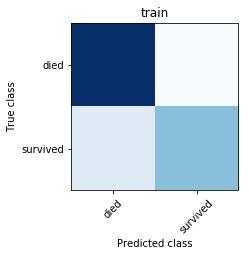

test ################################################################################
Accuracy: 0.8156424581005587
Precision: 0.8135593220338984
Recall: 0.6857142857142857



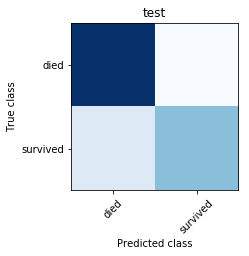

In [45]:
evaluate_model(knn_model, lr_extract_inputs, lr_extract_outputs)

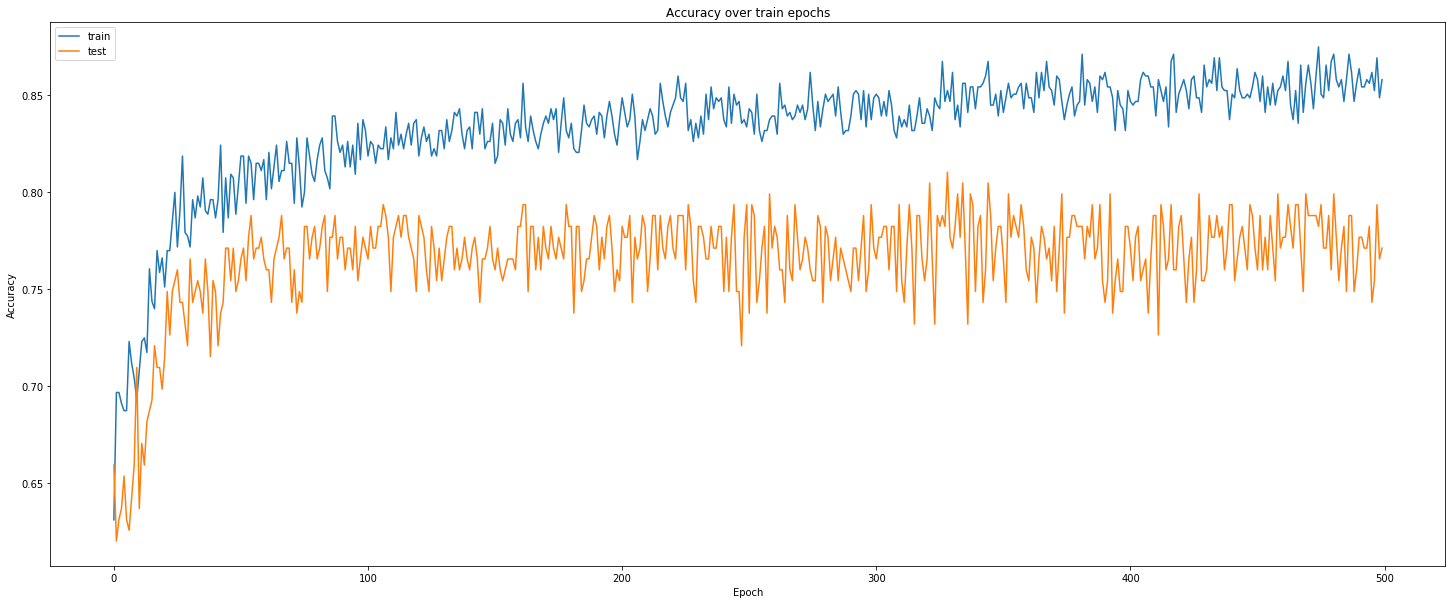

In [43]:
# plot accuracy over training epochs
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()